In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
# Load and normalize image function
def load_image(file_path, target_size=(128, 128)):
    image = tf.keras.preprocessing.image.load_img(file_path, color_mode="grayscale", target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0  # Normalize to [0, 1]
    return image

In [ ]:
def load_data(yes_dir, no_dir, target_size=(128, 128)):
    images = []
    masks = []
    labels = []

    # Load images from "yes" directory
    for image_file in os.listdir(yes_dir):
        image_path = os.path.join(yes_dir, image_file)
        image = load_image(image_path, target_size)
        mask = np.ones(target_size)  # Full mask for tumor present

        images.append(image)
        masks.append(mask[..., np.newaxis])  # Add channel dimension
        labels.append(1)  # Label for "yes"

    # Load images from "no" directory
    for image_file in os.listdir(no_dir):
        image_path = os.path.join(no_dir, image_file)
        image = load_image(image_path, target_size)
        mask = np.zeros(target_size)  # Blank mask for no tumor

        images.append(image)
        masks.append(mask[..., np.newaxis])  # Add channel dimension
        labels.append(0)  # Label for "no"

    return np.array(images), np.array(masks), np.array(labels)

In [ ]:
yes_dir = 'sample_data/brain/yes'
no_dir = 'sample_data/brain/no'

In [ ]:
# Load the data
images, masks, labels = load_data(yes_dir, no_dir)

# Split the data into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

In [ ]:
# Model Definition and Compilation
def unet(input_size=(128, 128, 1)):
    inputs = tf.keras.layers.Input(input_size)

    # Contracting path (Encoder)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive path (Decoder)
    u6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
# Instantiate and compile the model
model = unet(input_size=(128, 128, 1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 128, 128, 64)   │            640 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 64)     │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 128)    │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 16, 16, 256)    │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 8, 8, 512)      │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_28[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4        

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    batch_size=16,
    epochs=50
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.5867 - loss: 0.6894 - mean_io_u_1: 0.2024 - val_accuracy: 0.5294 - val_loss: 0.6837 - val_mean_io_u_1: 0.2353
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - accuracy: 0.6142 - loss: 0.6664 - mean_io_u_1: 0.1929 - val_accuracy: 0.5294 - val_loss: 0.6882 - val_mean_io_u_1: 0.2353
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.6252 - loss: 0.6527 - mean_io_u_1: 0.1874 - val_accuracy: 0.5294 - val_loss: 0.6816 - val_mean_io_u_1: 0.2353
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.6174 - loss: 0.6543 - mean_io_u_1: 0.1913 - val_accuracy: 0.5294 - val_loss: 0.6918 - val_mean_io_u_1: 0.2353
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - accuracy: 0.6267 - loss: 0.6473 - mean_io_u_1: 0.1866 - val_accuracy: 0.5294 - val_loss: 0.6850 - val_mean_io_u_1: 0.2353
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.5841 - loss: 0.6690 - mean_io_u_1: 0.2080 - val_accuracy

In [ ]:
def preprocess_image(file_path, target_size=(128, 128)):
    """Load and preprocess the image."""
    image = tf.keras.preprocessing.image.load_img(file_path, color_mode="grayscale", target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image / 255.0  # Normalize to [0, 1]
    return np.expand_dims(image, axis=0)  # Add batch dimension

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


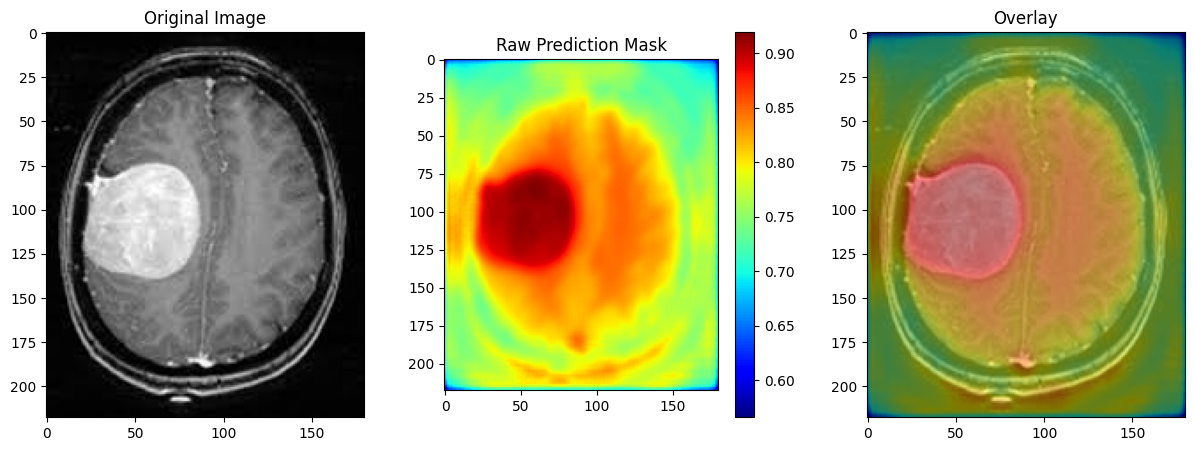

In [ ]:
def predict_and_visualize(image_path, model, target_size=(128, 128)):
    """Predict and visualize the segmentation mask with raw values."""
    # Preprocess the image
    test_image = preprocess_image(image_path, target_size)

    # Predict the segmentation mask
    predicted_mask = model.predict(test_image)

    # Load the original image for visualization
    original_image = tf.keras.preprocessing.image.load_img(image_path, color_mode="grayscale")
    original_image = tf.keras.preprocessing.image.img_to_array(original_image)

    # Resize predicted mask to match original image dimensions
    predicted_mask_resized = tf.image.resize(predicted_mask[0],
                                             (original_image.shape[0], original_image.shape[1]))
    predicted_mask_resized_np = np.squeeze(predicted_mask_resized.numpy())

    # Visualize the raw prediction mask and overlay
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(original_image), cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask_resized_np, cmap='jet')  # Using jet colormap to highlight prediction
    plt.colorbar()
    plt.title('Raw Prediction Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(original_image), cmap='gray')
    plt.imshow(predicted_mask_resized_np, cmap='jet', alpha=0.5)
    plt.title('Overlay')

    plt.show()

# Path to your image
image_path = '/content/sample_data/brain/yes/Y1.jpg'

# Predict and visualize
predict_and_visualize(image_path, model, target_size=(128, 128))